In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt
from utils import Histfit
import correctionlib

from distributed.diagnostics.plugin import UploadDirectory



awkward version  1.10.3
coffea version  0.7.21
awkward version  1.10.3
coffea version  0.7.21


In [2]:
from qcd_processor_lib import QCDProcessor
from qcd_processor_runner import runner
from processor_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
import mplhep as hep
hep.style.use("CMS")
plt.rcParams['figure.dpi'] = 60

In [5]:
# Set year and era here
year = 2018
era = "2018"
testing = False

In [6]:
hists = runner(testing = testing, year = year, era = era, prependstr = 'root://xcache/', nworkers = 1  )

Output()

KeyboardInterrupt: 

In [45]:
if testing == True:
    fname_out = 'test_QCD_pt_response_'+era+'JME'+'.pkl'
else:
    fname_out = 'QCD_pt_response_'+era+'JME'+'.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( hists, f )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f62d1ad3910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

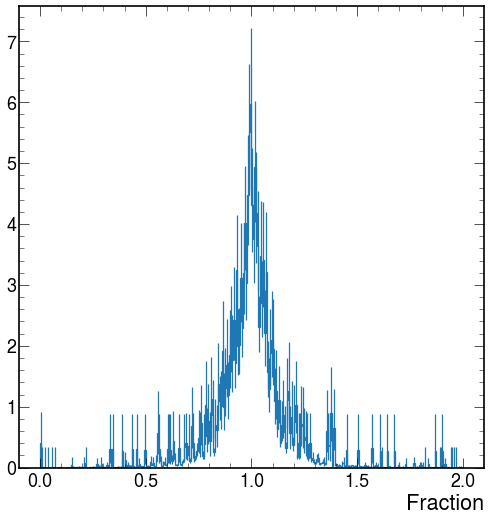

In [46]:
hists["pt_reco_over_gen"].project("frac").plot(density= True)